C:\Users\HP\AppData\Local\Temp\ipykernel_19896\3765339193.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


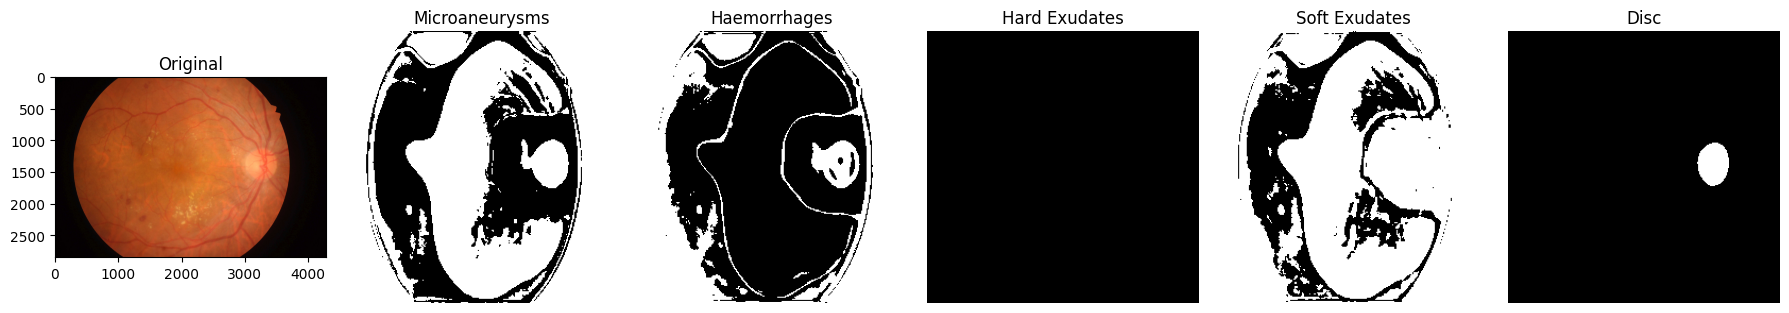


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_01.jpg:
Microaneurysms       | Pixels:  43179.0 | ✅ Present
Haemorrhages         | Pixels:  30488.0 | ✅ Present
Hard Exudates        | Pixels:      0.0 | ❌ Absent
Soft Exudates        | Pixels:  50782.0 | ✅ Present
Disc                 | Pixels:    940.0 | ✅ Present


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# UNet model definition (same as training)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        return self.conv_last(x)



# Load model + weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()


# Load test image

img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_01.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

# Predict

with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # use your calibration thresholds
# 0.05, 0.06, 0.19, 0.07, 0.35


#  Compute presence / absence

presence_summary = {}
for i, lesion in enumerate(lesions):
    pred_mask = (output[i] > otsu_thresholds[i]).astype(float)
    pixel_count = np.sum(pred_mask)
    presence_summary[lesion] = (pixel_count, "✅ Present" if pixel_count > 100 else "❌ Absent")


#  Display masks

plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    plt.subplot(1, 6, i + 2)
    plt.imshow((output[i] > otsu_thresholds[i]), cmap='gray')
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Print lesion summary

print(f"\n🩺 Results for {img_path}:")
for lesion, (count, status) in presence_summary.items():
    print(f"{lesion:20} | Pixels: {count:8} | {status}")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\250527121.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


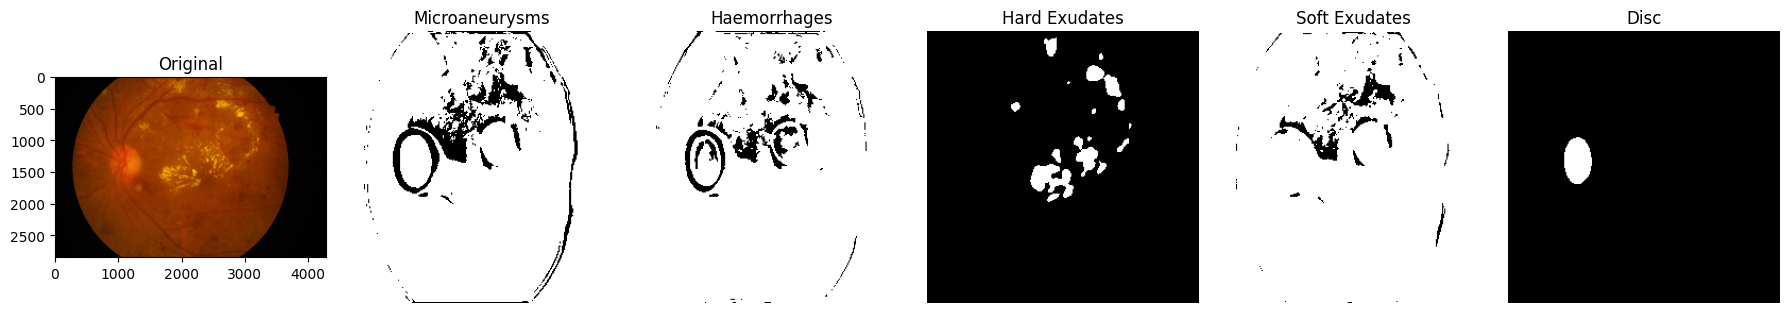


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_25.jpg:
Microaneurysms       | Pixels:  60198.0 | ✅ Present
Haemorrhages         | Pixels:  62190.0 | ✅ Present
Hard Exudates        | Pixels:   2146.0 | ✅ Present
Soft Exudates        | Pixels:  63281.0 | ✅ Present
Disc                 | Pixels:    903.0 | ✅ Present


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# UNet model definition (same as training)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        return self.conv_last(x)



# Load model + weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()


#  Load test image

img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_25.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)


# Predict

with torch.no_grad():
    output = torch.sigmoid(model(img_tensor))[0].cpu().numpy()

lesions = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
otsu_thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # use your calibration thresholds
# 0.05, 0.06, 0.19, 0.07, 0.35

# Compute presence / absence

presence_summary = {}
for i, lesion in enumerate(lesions):
    pred_mask = (output[i] > otsu_thresholds[i]).astype(float)
    pixel_count = np.sum(pred_mask)
    presence_summary[lesion] = (pixel_count, "✅ Present" if pixel_count > 100 else "❌ Absent")


# Display masks


plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.imshow(sample_image)
plt.title("Original")

for i, lesion in enumerate(lesions):
    plt.subplot(1, 6, i + 2)
    plt.imshow((output[i] > otsu_thresholds[i]), cmap='gray')
    plt.title(lesion)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Print lesion summary

print(f"\n🩺 Results for {img_path}:")
for lesion, (count, status) in presence_summary.items():
    print(f"{lesion:20} | Pixels: {count:8} | {status}")
